In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xmitgcm 

%matplotlib inline
import os
import imageio
import pandas as pd

import sys
from contextlib import contextmanager
from tqdm import tqdm
import glob


In [2]:
ds_sn = xmitgcm.open_mdsdataset('/home/ceoas/liux8/work/basin_modes/sulu_sea/res100_runs/exp7_cd_q_00025/',prefix=['outs_sn'])
ds_sn

<xarray.Dataset> Size: 2TB
Dimensions:  (XC: 1520, YC: 1908, XG: 1520, YG: 1908, Z: 57, Zp1: 58, Zu: 57,
              Zl: 57, time: 659)
Coordinates: (12/37)
  * XC       (XC) >f4 6kB 112.5 112.5 112.5 112.5 ... 127.7 127.7 127.7 127.7
  * YC       (YC) >f4 8kB -3.295 -3.285 -3.275 -3.265 ... 15.76 15.77 15.77
  * XG       (XG) >f4 6kB 112.5 112.5 112.5 112.5 ... 127.7 127.7 127.7 127.7
  * YG       (YG) >f4 8kB -3.3 -3.29 -3.28 -3.27 ... 15.74 15.75 15.76 15.77
  * Z        (Z) >f4 228B -12.5 -37.5 -62.5 ... -4.062e+03 -4.453e+03 -4.908e+03
  * Zp1      (Zp1) >f4 232B 0.0 -25.0 -50.0 ... -4.247e+03 -4.658e+03 -5.158e+03
    ...       ...
    maskInW  (YC, XG) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    dxF      (YC, XC) >f4 12MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    maskInC  (YC, XC) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    maskInS  (YG, XC) bool 3MB dask.array<chunksize=(1908, 1520), meta=np.ndarray>
    iter     (time) int64 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 5kB 00:00:00 00:03:00 ... 1 days 08:54:00
Data variables:
    UVEL     (time, Z, YC, XG) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    THETA    (time, Z, YC, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
    PHIHYD   (time, Z, YC, XC) float32 436GB dask.array<chunksize=(1, 57, 1908, 1520), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/home/ceoas/l...

# get depth-averaged velocity

In [3]:
uh = ds_sn.UVEL*ds_sn.drF*ds_sn.hFacW
h_u = ds_sn.hFacW*ds_sn.drF
u2d = uh.sum(dim='Z')/h_u.sum(dim='Z')
u_bc = ds_sn.UVEL.where(ds_sn.UVEL!=0)-u2d

vh = ds_sn.VVEL*ds_sn.drF*ds_sn.hFacS
h_v = ds_sn.hFacS*ds_sn.drF
v2d = vh.sum(dim='Z')/h_v.sum(dim='Z')
v_bc = ds_sn.VVEL.where(ds_sn.VVEL!=0)-v2d


/home/ceoas/liux8/.conda/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


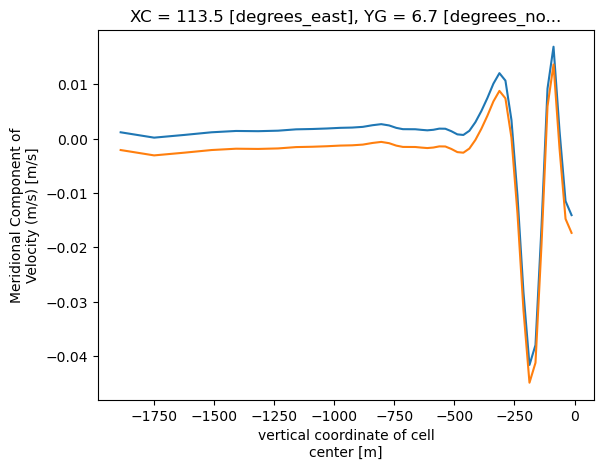

In [5]:
# u_bc.isel(XG=100, YC=1000,time=300).plot()
# ds_sn.UVEL.where(ds_sn.UVEL!=0).isel(XG=100, YC=1000,time=300).plot()

v_bc.isel(XC=100,YG=1000,time=300).plot()
ds_sn.VVEL.where(ds_sn.VVEL!=0).isel(XC=100,YG=1000,time=300).plot()


# get KE

In [10]:
ke_sum = np.zeros(len(ds_sn.time))
# ke_sur_sum = np.zeros(len(ds_sn.time))

ke_sum_inner = np.zeros(len(ds_sn.time))
# ke_sur_sum_inner = np.zeros(len(ds_sn.time))

ubc2 = u_bc**2
vbc2 = v_bc**2
dz = (ds_sn.hFacC*ds_sn.drF).values
ra = ds_sn.rA.values

for it in tqdm(range(len(ds_sn.time))):
# for it in range(10):
    # print it every 100 times
    # if it % 10 == 0:
    #     print(it)
    ubc2_0 = ubc2.isel(time=it).values
    vbc2_0 = vbc2.isel(time=it).values

    ke = 0.5*(ubc2_0+vbc2_0)*dz*ra

    ke_sum[it] = np.nansum(ke)
    ke_sum_inner[it] = np.nansum(ke[:,150:-150,150:-150])
    
    

  0%|          | 0/659 [00:00<?, ?it/s]/home/ceoas/liux8/.conda/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 659/659 [2:28:51<00:00, 13.55s/it]  


In [11]:
# save the ke_sum_inner, ke_sur_sum_inner, ke_sum_inner, ke_sur_sum_inner to a netcdf file
ds_ke = xr.Dataset({
    'ke_sum': (['time'], ke_sum),
    # 'ke_sur_sum_inner': (['time'], ke_sur_sum_inner),
    'ke_sum_inner': (['time'], ke_sum_inner),
    # 'ke_sur_sum_inner': (['time'], ke_sur_sum_inner)
})
ds_ke.to_netcdf('ke_sum_exp7_cd_q_00025_baroclinic.nc')

In [ ]:
drc = ds_sn.drF.values
dx = ds_sn.dxC.values
dy = ds_sn.dyC.values

ke_sum_total = np.zeros(len(ds_sn.time))
# ke_sur_sum = np.zeros(len(ds_sn.time))

# ke_sum_inner = np.zeros(len(ds_sn.time))
# ke_sur_sum_inner = np.zeros(len(ds_sn.time))

for it in range(len(ds_sn.time)):
    # print it every 100 times
    if it % 10 == 0:
        print(it)

    # mult water layer thickness
    # uvel = ds_sn.UVEL.isel(time=it,XG=slice(150,-150),YC=slice(150,-150)).values
    # vvel = ds_sn.VVEL.isel(time=it,XC=slice(150,-150),YG=slice(150,-150)).values
    
    uvel = ds_sn.UVEL.isel(time=it,).values
    vvel = ds_sn.VVEL.isel(time=it,).values
    # multiply uvel to horizontal grid size dx*dy   
    ke = 0.5*(uvel**2+vvel**2)*drc[:,None,None]*dx[None,:,:]*dy[None,:,:]
    ke_sum_total[it] = np.sum(ke)
    # ke_sur_sum[it] = np.sum(ke[0,:,:])

    # ke_sum_inner[it] = np.sum(ke[:,150:-150,150:-150])
    # ke_sur_sum_inner[it] = np.sum(ke[0,150:-150,150:-150])


In [59]:
# save the ke_sum_inner, ke_sur_sum_inner, ke_sum_inner, ke_sur_sum_inner to a netcdf file
ds_ke = xr.Dataset({
    'ke_sum_inner': (['time'], ke_sum_inner),
    'ke_sur_sum_inner': (['time'], ke_sur_sum_inner),
    'ke_sum_inner': (['time'], ke_sum_inner),
    'ke_sur_sum_inner': (['time'], ke_sur_sum_inner)
})
ds_ke.to_netcdf('ke_sum_exp7_cd_q_00025_barotropic_included.nc')

In [22]:
ds_ke = xr.open_dataset('ke_sum_exp7_cd_q_00025_baroclinic.nc')
ds_ke
# ke_sum_inner = ds_ke.ke_sum_inner

<xarray.Dataset> Size: 11kB
Dimensions:       (time: 659)
Dimensions without coordinates: time
Data variables:
    ke_sum        (time) float64 5kB ...
    ke_sum_inner  (time) float64 5kB ...

Text(0, 0.5, 'KE integrated (m^2/s^2*m^3)')

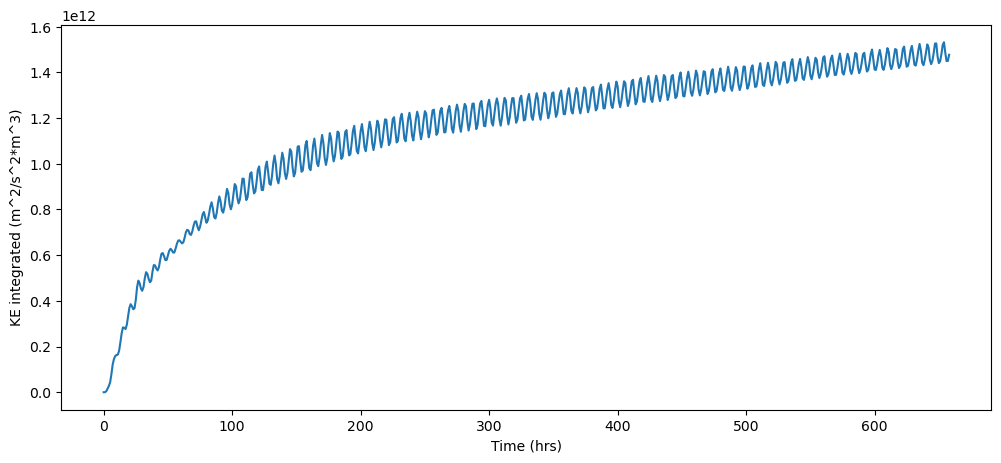

In [10]:
plt.figure(figsize=(12,5))
# plt.plot(ke_sur_sum_inner)
plt.plot(ke_sum_inner.values)
plt.xlabel('Time (hrs)')
plt.ylabel('KE integrated (m^2/s^2*m^3)')
# plt.plot(ke_sum)

In [19]:
# depth = ds_sn.Depth.values
# ke_bt = 0.5*(u2d.values**2+v2d.values**2)*depth[None,:,:]*dx[None,:,:]*dy[None,:,:]


ubt2 = u2d**2
vbt2 = v2d**2
dz = (ds_sn.Depth).values
ra = ds_sn.rA.values

ke_bt_sum_total = np.zeros(len(ds_sn.time))

# Process in batches for efficiency
batch_size = 50  # Process 50 time steps at a time
n_time = len(ds_sn.time)
n_batches = (n_time + batch_size - 1) // batch_size

for batch_idx in tqdm(range(n_batches)):
    start_idx = batch_idx * batch_size
    end_idx = min(start_idx + batch_size, n_time)
    
    # Load batch of time steps
    ubt2_batch = ubt2.isel(time=slice(start_idx, end_idx)).values
    vbt2_batch = vbt2.isel(time=slice(start_idx, end_idx)).values
    
    # Vectorized computation for this batch
    # Shape: (batch_time, Y, X)
    ke_bt_batch = 0.5 * (ubt2_batch + vbt2_batch) * dz[None, :, :] * ra[None, :, :]
    
    # Compute sums for this batch
    ke_bt_sum_total[start_idx:end_idx] = np.nansum(ke_bt_batch, axis=(1, 2))
    
    # Clear batch from memory
    del ubt2_batch, vbt2_batch, ke_bt_batch


  0%|          | 0/14 [00:00<?, ?it/s]/home/ceoas/liux8/.conda/envs/py311/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 14/14 [55:24<00:00, 237.47s/it]


In [20]:
# save the ke_sum_inner, ke_sur_sum_inner, ke_sum_inner, ke_sur_sum_inner to a netcdf file
ds_ke_bt = xr.Dataset({
    'ke_sum': (['time'], ke_bt_sum_total),
    # 'ke_sur_sum_inner': (['time'], ke_sur_sum_inner),
    # 'ke_sum_inner': (['time'], ke_sum_inner),
    # 'ke_sur_sum_inner': (['time'], ke_sur_sum_inner)
})
ds_ke_bt.to_netcdf('ke_sum_exp7_cd_q_00025_barotropic.nc')

(600.0, 690.9)

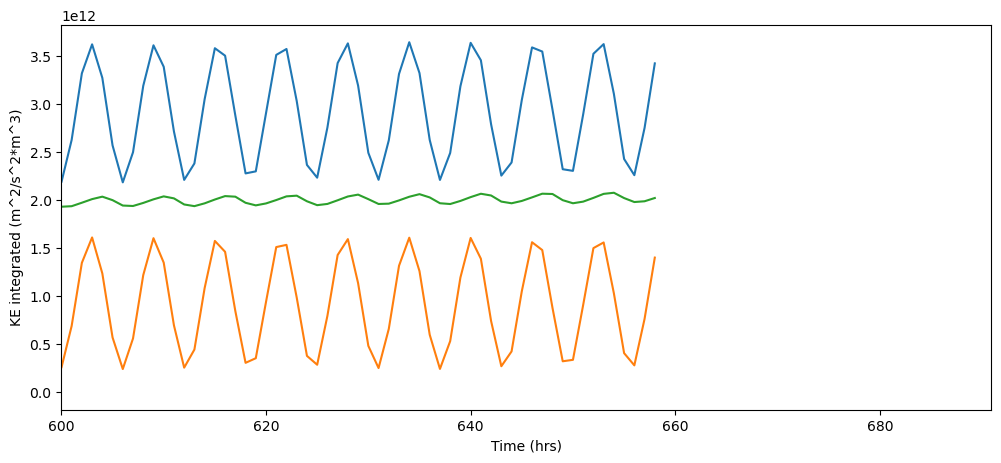

In [26]:
plt.figure(figsize=(12,5))
# plt.plot(ke_sur_sum_inner)
plt.plot(ds_ke_bt.ke_sum.values+ds_ke.ke_sum.values)
plt.plot(ds_ke_bt.ke_sum.values)
plt.plot(ds_ke.ke_sum.values)
plt.xlabel('Time (hrs)')
plt.ylabel('KE integrated (m^2/s^2*m^3)')
# plt.plot(ke_sum)
plt.xlim(600,None)

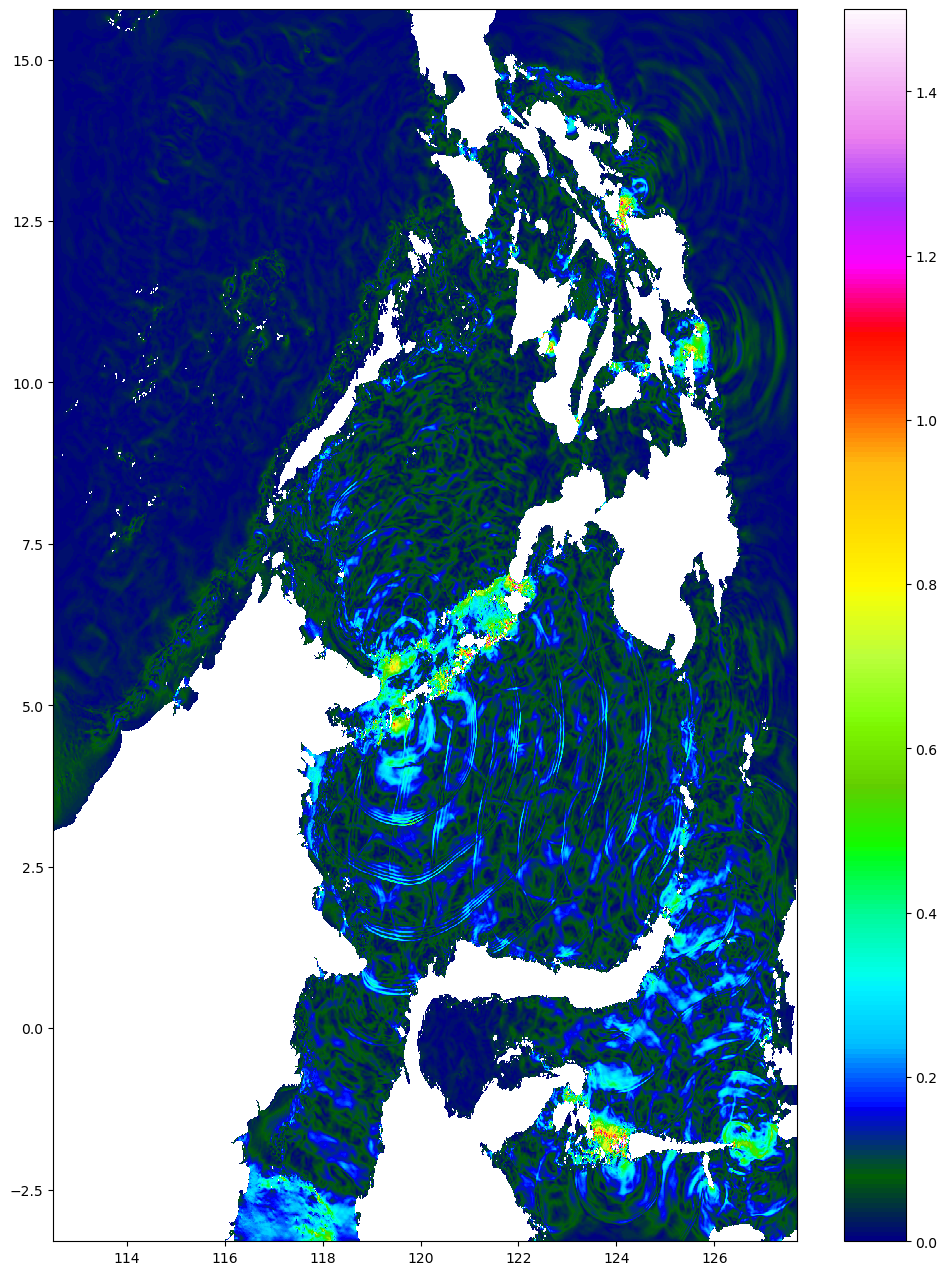

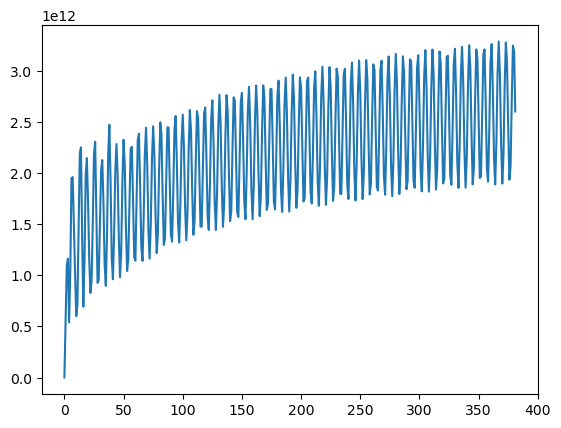

In [7]:
# read STDOUT.0000
stdout_0000 = open('/home/ceoas/liux8/work/basin_modes/sulu_sea/res100_runs/exp7_cd_q_00025/STDOUT.0000','r').read()

# find the line that contains 'ke_mean'
# do loop for all the lines
# save ke_mean to a list
ke_mean_list = []
ke_vol_list = []
for line in stdout_0000.split('\n'):
    if 'ke_mean' in line:
        ke_mean_line = line
        # break
        ke_mean = float(ke_mean_line.split('=')[-1].strip())
        # print(ke_mean)
        ke_mean_list.append(ke_mean)
    elif 'ke_vol' in line:
        ke_vol_line = line
        ke_vol = float(ke_vol_line.split('=')[-1].strip())
        ke_vol_list.append(ke_vol)
# convert ke_mean_list to a numpy array
ke_mean_array = np.array(ke_mean_list)
ke_vol_array = np.array(ke_vol_list)
# plot ke_mean_array
plt.plot(ke_mean_array*ke_vol_array)


Text(0, 0.5, 'KE integrated')

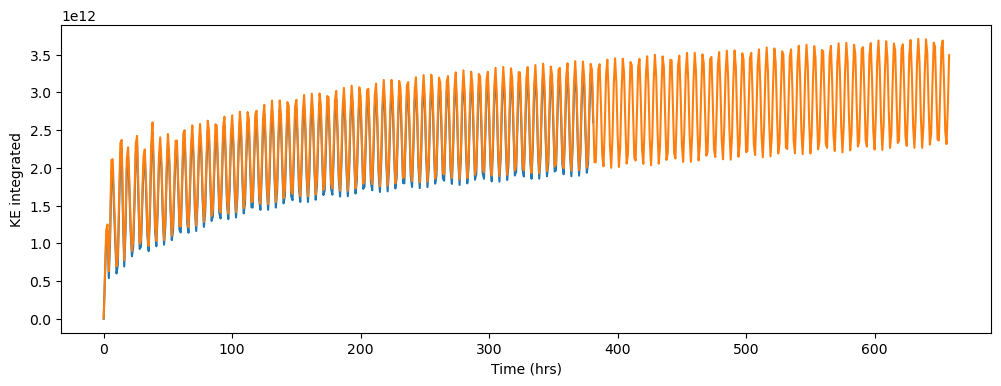

In [19]:
plt.figure(figsize=(12,4))
plt.plot(ke_mean_array*ke_vol_array)
plt.plot(ke_sum)
plt.xlabel('Time (hrs)')
plt.ylabel('KE integrated')

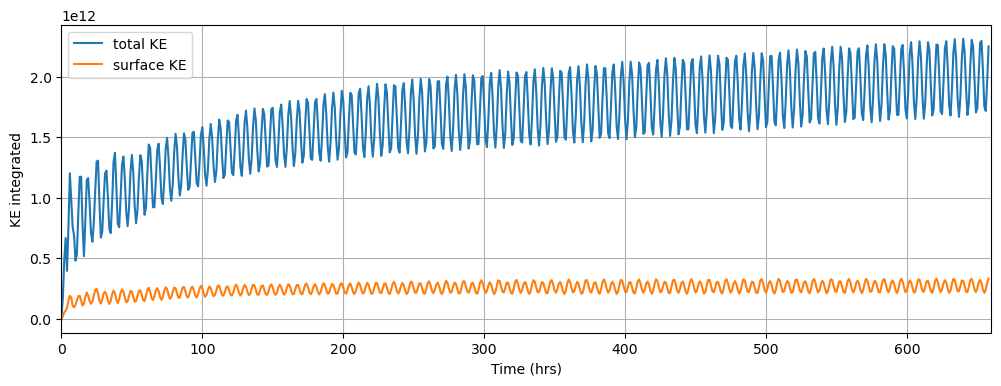

In [18]:
plt.figure(figsize=(12,4))
# plt.plot(ke_mean_array*ke_vol_array)
plt.plot(ke_sum_inner,label='total KE')
plt.plot(ke_sur_sum_inner,label='surface KE')
plt.xlabel('Time (hrs)')
plt.ylabel('KE integrated')
plt.xlim(0,660)
plt.grid()
plt.legend()